In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from data_cleanup import *
from feature_selection import *
from model_ import *

from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as rmse
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = load_reduced_df()

In [3]:
corr_cols = ['ti_cpi', 'bci_bci', 'ti_cpi_om','vdem_corr', 'vdem_execorr', 'vdem_jucorrdc', 'vdem_pubcorr', 'wbgi_cce']

### Feature selection

In [4]:
%pwd

'/home/david/TU/DOPP'

In [10]:
df = drop_date_columns(df)

best_features_dict = {}
selected_features_dict = {}

for target_col in corr_cols:
    X_train, X_test, y_train, y_test = create_traintestsplit(df, target_col=target_col)
    best_features = pre_select(X_train, y_train)
    best_features = filter_corruption(best_features)
    best_features_dict[target_col] = set(best_features)
    
    selected_features_dict[target_col] = set(filter_highly_correleated(X_train, best_features))




5
Index(['ccode', 'cname', 'year', 'ccode_qog', 'cname_qog', 'ccodealp',
       'version', 'cname_year', 'ccodealp_year', 'bci_bci', 'bci_bcistd',
       'bmr_dem', 'bmr_dembr', 'bmr_demdur', 'bmr_demfsuf'],
      dtype='object')
5
Index(['ccode', 'cname', 'year', 'ccode_qog', 'cname_qog', 'ccodealp',
       'version', 'cname_year', 'ccodealp_year', 'bci_bci', 'bci_bcistd',
       'bmr_dem', 'bmr_dembr', 'bmr_demdur', 'bmr_demfsuf'],
      dtype='object')
5
Index(['ccode', 'cname', 'year', 'ccode_qog', 'cname_qog', 'ccodealp',
       'version', 'cname_year', 'ccodealp_year', 'bci_bci', 'bci_bcistd',
       'bmr_dem', 'bmr_dembr', 'bmr_demdur', 'bmr_demfsuf'],
      dtype='object')
5
Index(['ccode', 'cname', 'year', 'ccode_qog', 'cname_qog', 'ccodealp',
       'version', 'cname_year', 'ccodealp_year', 'bci_bci', 'bci_bcistd',
       'bmr_dem', 'bmr_dembr', 'bmr_demdur', 'bmr_demfsuf'],
      dtype='object')
5
Index(['ccode', 'cname', 'year', 'ccode_qog', 'cname_qog', 'ccodealp',
       

In [5]:
best_features_union=list(set.union(*list(best_features_dict.values())))
best_features_intersection=list(set.intersection(*list(best_features_dict.values())))

best_features_intersection

['vdem_egaldem', 'wbgi_rle', 'wbgi_rqe', 'wbgi_gee', 'wbgi_vae', 'vdem_egal']

In [6]:
selected_features_union=list(set.union(*list(selected_features_dict.values())))
selected_features_intersection=list(set.intersection(*list(selected_features_dict.values())))

selected_features_intersection

['wbgi_rle', 'wbgi_vae', 'vdem_egal', 'wbgi_rqe']

## Modeling

Try Lasso and Random Forest next. Train models for different feature configurations 

    - individual selected features for a particular index
    - union of all good features for all indices
    - intersection of all selected for features for all indices

As scores r2 and rmse are reported. The comparisons are based on r2-scores as they make the scores for different indices comparable.
    

### Lasso
The used library uses cross validation to determine a good value for alpha.

The following script trains for all target indices a Lasso model, then displays r2 score and feature importance information. 

In [7]:
def lasso_info_script(features):
    lasso_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            lasso_bf[target] = apply_lassocv(df, target, list(features[target]), fprint=False)
        else:
            lasso_bf[target] = apply_lassocv(df, target, features, fprint=False)
        df_score.loc[target,] = [lasso_bf[target]['r2'] ,lasso_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [lasso_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [lasso_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)
    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()


First we apply the script for the individually selected features for each corruption index.

scores


,r2,rmse
bci_bci,0.642326,72.707022
ti_cpi,0.46208,252.350794
vdem_corr,0.661762,0.027632
vdem_execorr,0.611727,0.032012
vdem_jucorrdc,0.336575,0.442835
vdem_pubcorr,0.679814,0.026126
wbgi_cce,0.850616,0.123031


feature importance


,vdem_liberal,ihme_lifexp_0104m,wbgi_rle,wbgi_pve,wbgi_rqe,ihme_lifexp_0104t,wbgi_vae,vdem_egal,wbgi_pvs,vdem_egaldem,wbgi_pvn,vdem_polyarchy
bci_bci,0.067652,0.010755,0.775876,0.0,0.0,0.0,0.145718,0.0,NaN,NaN,NaN,NaN
ti_cpi,NaN,0.066021,0.18004,NaN,0.011819,0.054354,0.076577,0.010895,0.399422,0.057749,0.143122,NaN
vdem_corr,NaN,NaN,0.533389,0.030238,0.089669,NaN,0.059857,0.134334,NaN,NaN,NaN,0.152513
vdem_execorr,NaN,NaN,0.556451,NaN,0.0,NaN,0.0,0.225707,NaN,NaN,NaN,0.217842
vdem_jucorrdc,NaN,NaN,0.794687,0.003495,0.0,NaN,0.113602,0.010913,NaN,NaN,NaN,0.077303
vdem_pubcorr,NaN,NaN,0.454955,0.030006,0.0,NaN,0.11044,0.162956,NaN,NaN,NaN,0.241642
wbgi_cce,NaN,NaN,0.941758,0.019515,0.0,NaN,0.036767,0.00196,NaN,NaN,NaN,0.0



feature importance rank


,vdem_liberal,ihme_lifexp_0104m,wbgi_rle,wbgi_pve,wbgi_rqe,ihme_lifexp_0104t,wbgi_vae,vdem_egal,wbgi_pvs,vdem_egaldem,wbgi_pvn,vdem_polyarchy
bci_bci,3,4,1,<NA>,<NA>,<NA>,2,<NA>,<NA>,<NA>,<NA>,<NA>
ti_cpi,<NA>,5,2,<NA>,8,7,4,9,1,6,3,<NA>
vdem_corr,<NA>,<NA>,1,6,4,<NA>,5,3,<NA>,<NA>,<NA>,2
vdem_execorr,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,2,<NA>,<NA>,<NA>,3
vdem_jucorrdc,<NA>,<NA>,1,5,<NA>,<NA>,2,4,<NA>,<NA>,<NA>,3
vdem_pubcorr,<NA>,<NA>,1,5,<NA>,<NA>,4,3,<NA>,<NA>,<NA>,2
wbgi_cce,<NA>,<NA>,1,3,<NA>,<NA>,2,4,<NA>,<NA>,<NA>,<NA>


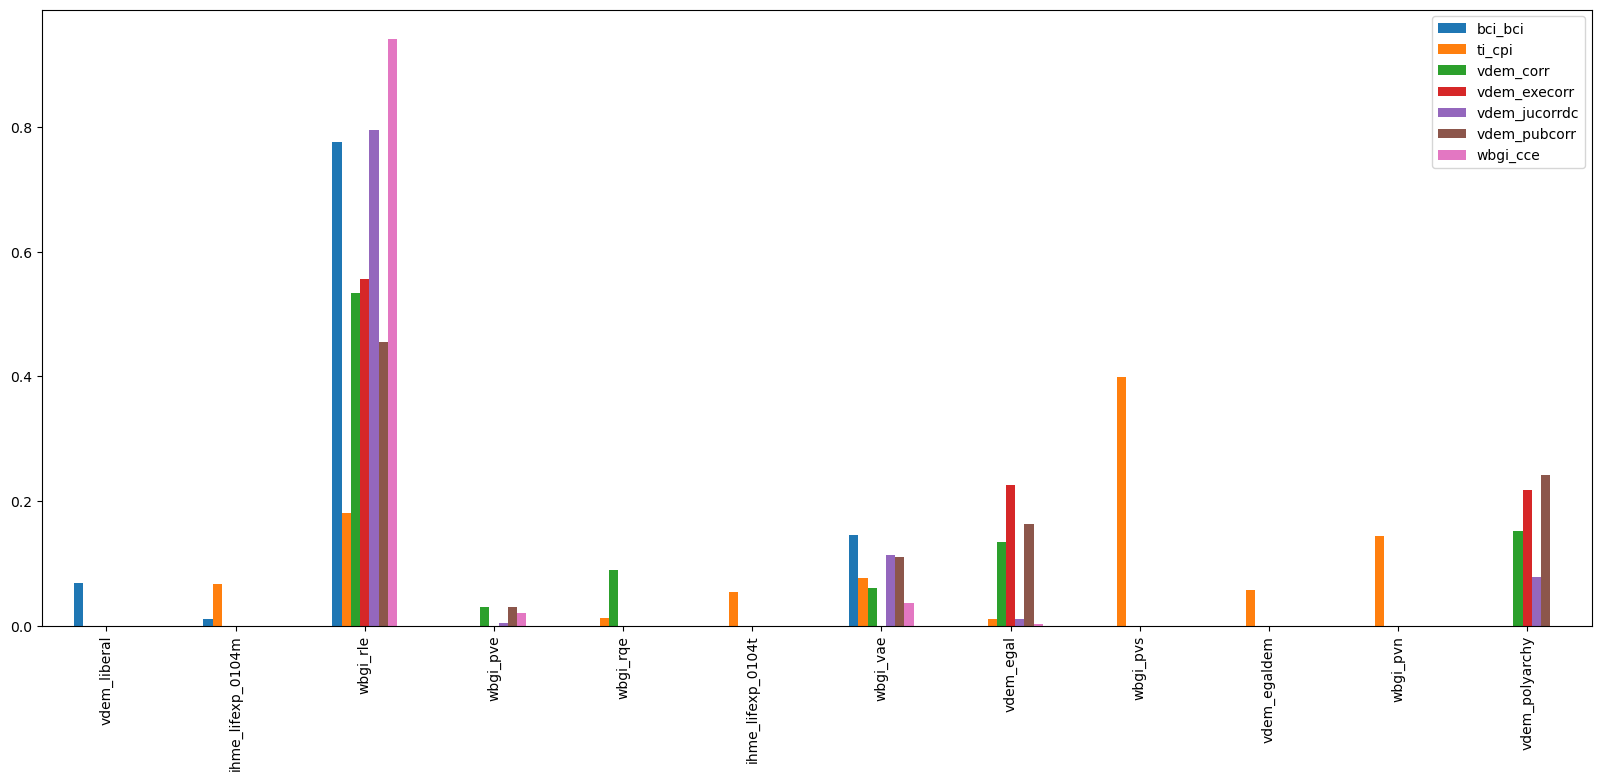

In [8]:
lasso_info_script(selected_features_dict)

Next we use for all corruption indices the same set of features - the set of all as promising declared features.

scores


,r2,rmse
bci_bci,0.705076,59.951495
ti_cpi,0.47722,245.248291
vdem_corr,0.686953,0.025574
vdem_execorr,0.617306,0.031552
vdem_jucorrdc,0.453032,0.3651
vdem_pubcorr,0.690376,0.025264
wbgi_cce,0.871308,0.105989


feature importance


,vdem_libdem,fh_pr,wbgi_rle,vdem_edcomp_thick,wbgi_rqe,ihme_hle_0104f,wbgi_gee,ihme_lifexp_0104t,wbgi_pvs,ihme_lifexp_0104f,...,ihme_hle_0104t,ihme_hle_0104m,wbgi_pve,vdem_polyarchy,vdem_delibdem,vdem_egaldem,fh_status,wbgi_vae,wbgi_pvn,vdem_egal
bci_bci,0.0,0.0,0.365958,0.0,0.0,0.058446,0.239384,0.0,0.051106,0.0,...,0.0,0.0,0.0,0.051499,0.0,0.0,0.044664,0.0,0.080439,0.0
ti_cpi,0.0,0.0,0.149456,0.023356,0.0,0.028561,0.0,0.0,0.390097,0.0,...,0.0,0.0,0.021109,0.0,0.037413,0.0,0.0,0.114121,0.1267,0.0
vdem_corr,0.327828,0.004238,0.104652,0.0,0.045761,0.0,0.141575,0.011338,0.040825,0.004669,...,0.0,0.0,0.019094,0.07761,0.006282,0.0,0.0,0.0,0.044177,0.046164
vdem_execorr,0.186082,0.0,0.213041,0.00581,0.00948,0.0,0.188907,0.0,0.007012,0.0,...,0.0,0.0,0.013606,0.0,0.0,0.0,0.0,0.0,0.0,0.112197
vdem_jucorrdc,0.251877,0.017332,0.069254,0.078339,0.031567,0.0,0.069396,0.0,0.022201,0.013711,...,0.018969,0.00061,0.002489,0.186933,0.05176,0.0,0.006373,0.068341,0.023163,0.013249
vdem_pubcorr,0.210297,0.0,0.124503,0.001976,0.019788,0.0,0.237116,0.0,0.033585,0.015762,...,0.0,0.0,0.035976,0.0,0.0,0.0,0.0,0.048722,0.053101,0.098135
wbgi_cce,0.014362,0.0,0.395785,0.0,0.018698,0.058762,0.29118,0.0,0.044395,0.0,...,0.0,0.0,0.009908,0.0,0.0,0.013855,0.013039,0.021261,0.081198,0.0



feature importance rank


,vdem_libdem,fh_pr,wbgi_rle,vdem_edcomp_thick,wbgi_rqe,ihme_hle_0104f,wbgi_gee,ihme_lifexp_0104t,wbgi_pvs,ihme_lifexp_0104f,...,ihme_hle_0104t,ihme_hle_0104m,wbgi_pve,vdem_polyarchy,vdem_delibdem,vdem_egaldem,fh_status,wbgi_vae,wbgi_pvn,vdem_egal
bci_bci,<NA>,<NA>,1,<NA>,<NA>,4,2,<NA>,8,<NA>,...,<NA>,<NA>,<NA>,7,<NA>,<NA>,9,<NA>,3,<NA>
ti_cpi,<NA>,<NA>,2,9,<NA>,8,<NA>,<NA>,1,<NA>,...,<NA>,<NA>,10,<NA>,6,<NA>,<NA>,4,3,<NA>
vdem_corr,1,15,3,<NA>,7,<NA>,2,12,9,14,...,<NA>,<NA>,11,5,13,<NA>,<NA>,<NA>,8,6
vdem_execorr,3,<NA>,1,10,8,<NA>,2,<NA>,9,<NA>,...,<NA>,<NA>,7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,5
vdem_jucorrdc,1,14,5,3,9,<NA>,4,<NA>,12,15,...,13,20,19,2,7,<NA>,17,6,11,16
vdem_pubcorr,2,<NA>,3,14,12,<NA>,1,<NA>,9,13,...,<NA>,<NA>,8,<NA>,<NA>,<NA>,<NA>,7,6,4
wbgi_cce,9,<NA>,1,<NA>,8,4,2,<NA>,5,<NA>,...,<NA>,<NA>,12,<NA>,<NA>,10,11,7,3,<NA>


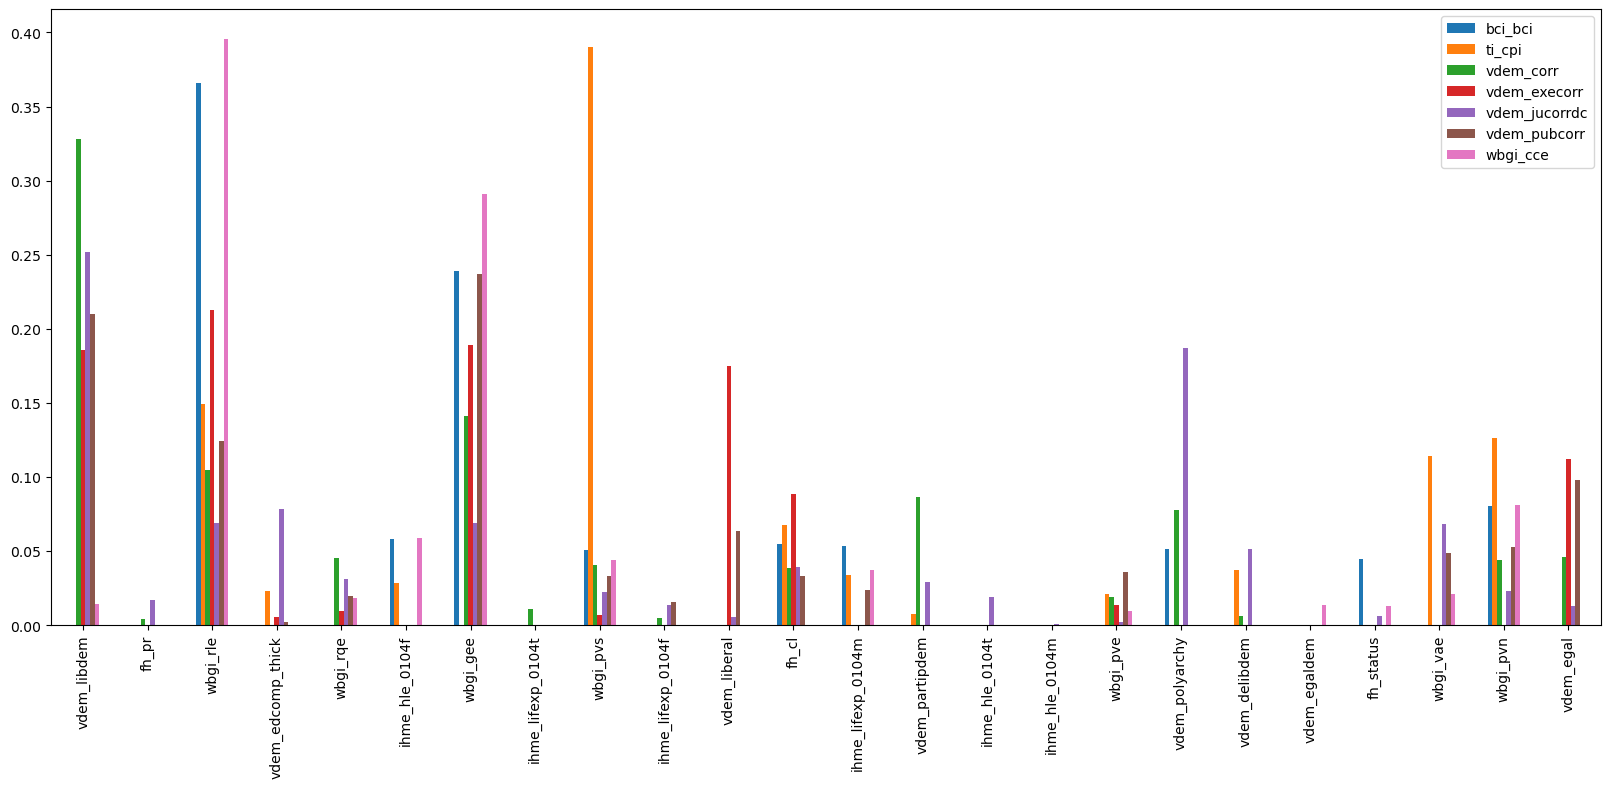

In [9]:
lasso_info_script(best_features_union)

Now we use only the features that are in all individually selected feature sets.

scores


,r2,rmse
bci_bci,0.640953,72.986303
ti_cpi,0.093176,425.41252
vdem_corr,0.652719,0.028371
vdem_execorr,0.602062,0.032809
vdem_jucorrdc,0.332133,0.4458
vdem_pubcorr,0.684928,0.025709
wbgi_cce,0.848395,0.12486


feature importance


,wbgi_rle,wbgi_vae,vdem_egal,wbgi_rqe
bci_bci,0.772239,0.212816,0.014944,0.0
ti_cpi,1.0,0.0,0.0,0.0
vdem_corr,0.587571,0.125321,0.186455,0.100653
vdem_execorr,0.505538,0.227506,0.266957,0.0
vdem_jucorrdc,0.77111,0.205012,0.023877,0.0
vdem_pubcorr,0.533446,0.198988,0.267566,0.0
wbgi_cce,0.958001,0.037146,0.004854,0.0



feature importance rank


,wbgi_rle,wbgi_vae,vdem_egal,wbgi_rqe
bci_bci,1,2,3,<NA>
ti_cpi,1,<NA>,<NA>,<NA>
vdem_corr,1,3,2,4
vdem_execorr,1,3,2,<NA>
vdem_jucorrdc,1,2,3,<NA>
vdem_pubcorr,1,3,2,<NA>
wbgi_cce,1,2,3,<NA>


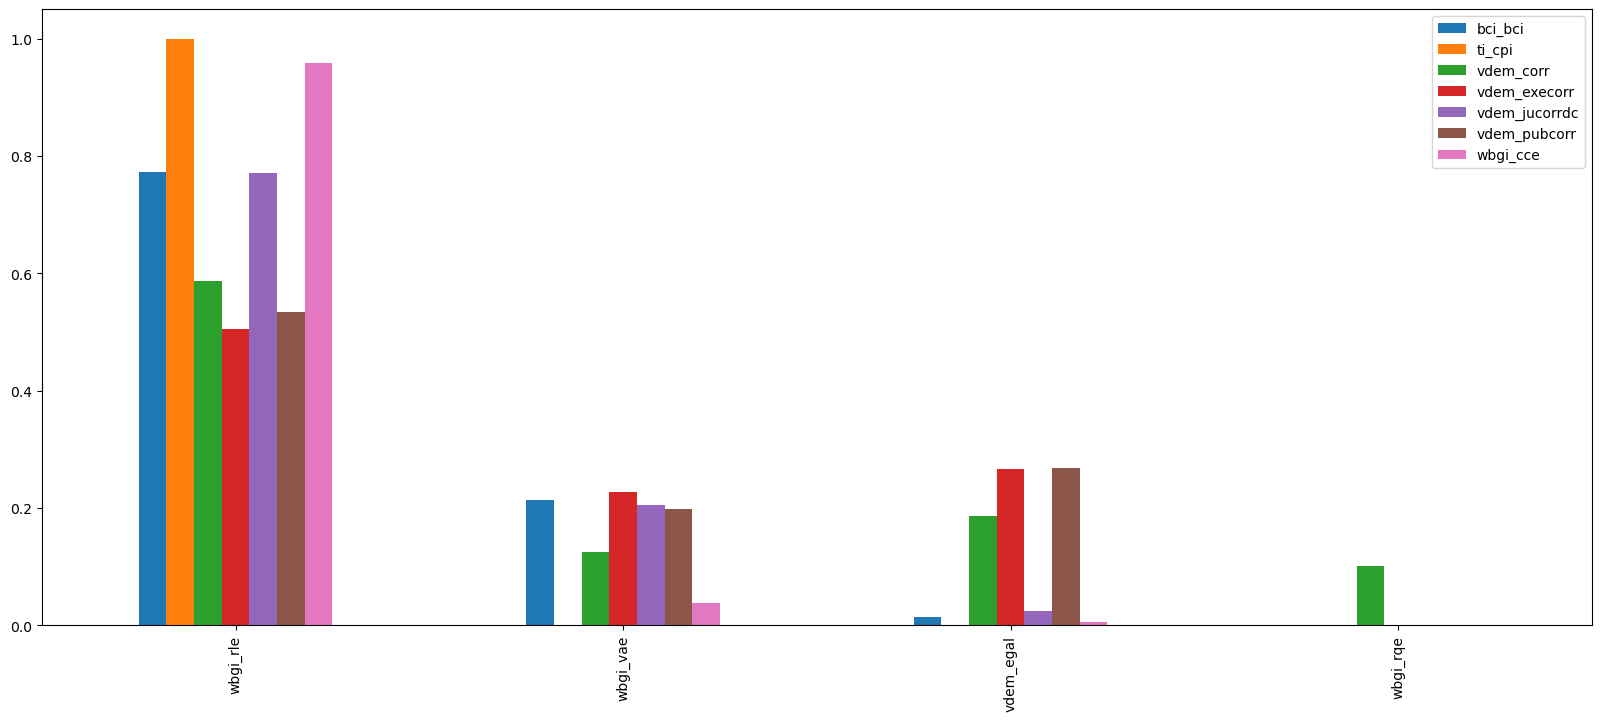

In [10]:
lasso_info_script(selected_features_intersection)

Findings:

- wbgi_rle (Rule of Law) is by far the most important feature in almost all configurations
- most indices behave similarly for the three feature set configuration but
- ti_cpi is most different: its score is very bad with the smallest feature set. Its most important feature is wbgi_pvs [Political Stability and Absence of Violence/Terrorism, Standard error] and not wbgi_rle
- vdem_jucorrdc is also effected more by different feature sets and its score is lower as well in general.
- all the other indices gain information slightly by more features but they do not rely too much on the chosen setups

### Random Forest

Next we do the same for a Random Forest Regressor. Here initially no cross validation is done. We just use a default setup at first.

In [11]:
def rf_info_script(features):
    rf_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_rf(df, target, list(features[target]), fprint=False)
        else:
            rf_bf[target] = apply_rf(df, target, features, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()



First we apply again the script for the individually selected features for each corruption index.

scores


,r2,rmse
bci_bci,0.639638,73.253426
ti_cpi,0.937015,29.547806
vdem_corr,0.717872,0.023048
vdem_execorr,0.592474,0.033599
vdem_jucorrdc,0.333833,0.444665
vdem_pubcorr,0.640826,0.029308
wbgi_cce,0.855328,0.11915


feature importance


,vdem_liberal,ihme_lifexp_0104m,wbgi_rle,wbgi_pve,wbgi_rqe,ihme_lifexp_0104t,wbgi_vae,vdem_egal,wbgi_pvs,vdem_egaldem,wbgi_pvn,vdem_polyarchy
bci_bci,0.04857,0.009338,0.852444,0.013179,0.014183,0.010048,0.02865,0.023589,NaN,NaN,NaN,NaN
ti_cpi,NaN,0.003076,0.273881,NaN,0.012166,0.001953,0.005829,0.00985,0.669397,0.003311,0.020535,NaN
vdem_corr,NaN,NaN,0.51368,0.024392,0.018467,NaN,0.080883,0.311515,NaN,NaN,NaN,0.051063
vdem_execorr,NaN,NaN,0.182267,NaN,0.039988,NaN,0.06723,0.629966,NaN,NaN,NaN,0.080549
vdem_jucorrdc,NaN,NaN,0.758006,0.023079,0.031937,NaN,0.091658,0.052566,NaN,NaN,NaN,0.042754
vdem_pubcorr,NaN,NaN,0.500134,0.0157,0.021849,NaN,0.070338,0.283436,NaN,NaN,NaN,0.108544
wbgi_cce,NaN,NaN,0.944403,0.010082,0.01099,NaN,0.013222,0.010255,NaN,NaN,NaN,0.011049



feature importance rank


,vdem_liberal,ihme_lifexp_0104m,wbgi_rle,wbgi_pve,wbgi_rqe,ihme_lifexp_0104t,wbgi_vae,vdem_egal,wbgi_pvs,vdem_egaldem,wbgi_pvn,vdem_polyarchy
bci_bci,2,8,1,6,5,7,3,4,<NA>,<NA>,<NA>,<NA>
ti_cpi,<NA>,8,2,<NA>,4,9,6,5,1,7,3,<NA>
vdem_corr,<NA>,<NA>,1,5,6,<NA>,3,2,<NA>,<NA>,<NA>,4
vdem_execorr,<NA>,<NA>,2,<NA>,5,<NA>,4,1,<NA>,<NA>,<NA>,3
vdem_jucorrdc,<NA>,<NA>,1,6,5,<NA>,2,3,<NA>,<NA>,<NA>,4
vdem_pubcorr,<NA>,<NA>,1,6,5,<NA>,4,2,<NA>,<NA>,<NA>,3
wbgi_cce,<NA>,<NA>,1,6,4,<NA>,2,5,<NA>,<NA>,<NA>,3


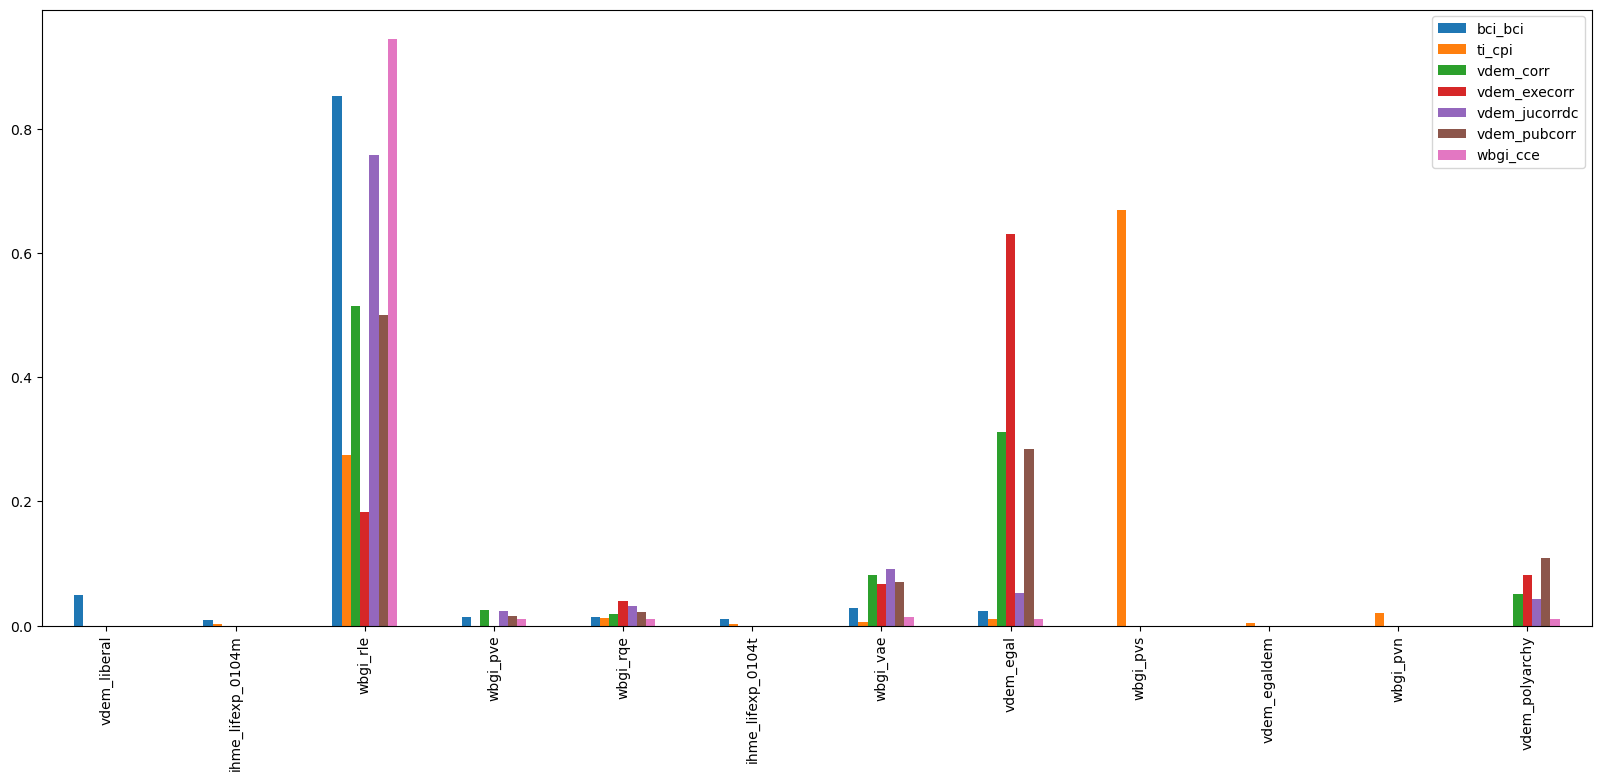

In [12]:
rf_info_script(selected_features_dict)

Next we use for all corruption indices the same set of features - the set of all as promising declared features.

scores


,r2,rmse
bci_bci,0.67799,65.457512
ti_cpi,0.940155,28.074741
vdem_corr,0.660468,0.027738
vdem_execorr,0.628831,0.030602
vdem_jucorrdc,0.333882,0.444632
vdem_pubcorr,0.643676,0.029075
wbgi_cce,0.863597,0.11234


feature importance


,vdem_libdem,fh_pr,wbgi_rle,vdem_edcomp_thick,wbgi_rqe,ihme_hle_0104f,wbgi_gee,ihme_lifexp_0104t,wbgi_pvs,ihme_lifexp_0104f,...,ihme_hle_0104t,ihme_hle_0104m,wbgi_pve,vdem_polyarchy,vdem_delibdem,vdem_egaldem,fh_status,wbgi_vae,wbgi_pvn,vdem_egal
bci_bci,0.019111,0.001683,0.489467,0.00569,0.006898,0.005163,0.365132,0.002063,0.002349,0.003355,...,0.002227,0.003129,0.007056,0.023374,0.008902,0.006312,0.001346,0.007517,0.003706,0.010507
ti_cpi,0.000814,0.000205,0.267263,0.001832,0.009684,0.000991,0.007433,0.000833,0.664598,0.000972,...,0.000968,0.000929,0.006435,0.001271,0.001773,0.001701,0.000186,0.003445,0.017456,0.004845
vdem_corr,0.062347,0.001332,0.433024,0.010301,0.006579,0.00496,0.025912,0.002225,0.00192,0.003967,...,0.002589,0.003976,0.014546,0.00773,0.005366,0.00747,0.000348,0.017796,0.001472,0.268709
vdem_execorr,0.09223,0.002335,0.097226,0.013606,0.009676,0.004014,0.04294,0.00245,0.003505,0.003124,...,0.002659,0.004199,0.012994,0.008092,0.016214,0.014857,0.000533,0.013566,0.002093,0.468104
vdem_jucorrdc,0.011813,0.001297,0.684026,0.013187,0.007494,0.005229,0.027065,0.003928,0.002165,0.004374,...,0.003746,0.006878,0.011429,0.006202,0.007224,0.006928,0.000425,0.042367,0.002148,0.021985
vdem_pubcorr,0.111827,0.001374,0.262987,0.008191,0.00683,0.00535,0.152265,0.002017,0.002703,0.003475,...,0.001978,0.003276,0.015359,0.006844,0.004829,0.167748,0.000345,0.004359,0.001495,0.168877
wbgi_cce,0.002433,0.000486,0.874712,0.002321,0.005024,0.002076,0.074373,0.000894,0.002077,0.001578,...,0.000951,0.001194,0.00652,0.002052,0.001642,0.002554,0.000152,0.005851,0.001112,0.004456



feature importance rank


,vdem_libdem,fh_pr,wbgi_rle,vdem_edcomp_thick,wbgi_rqe,ihme_hle_0104f,wbgi_gee,ihme_lifexp_0104t,wbgi_pvs,ihme_lifexp_0104f,...,ihme_hle_0104t,ihme_hle_0104m,wbgi_pve,vdem_polyarchy,vdem_delibdem,vdem_egaldem,fh_status,wbgi_vae,wbgi_pvn,vdem_egal
bci_bci,4,23,1,13,11,14,2,21,19,16,...,20,17,10,3,8,12,24,9,15,5
ti_cpi,21,23,2,11,4,16,5,20,1,17,...,18,19,6,15,12,13,24,8,3,7
vdem_corr,4,22,1,8,11,15,5,19,20,17,...,18,16,7,9,14,10,24,6,21,2
vdem_execorr,4,22,3,8,12,16,5,21,17,18,...,19,15,10,13,6,7,24,9,23,1
vdem_jucorrdc,7,23,1,6,10,16,4,18,20,17,...,19,13,8,14,11,12,24,3,21,5
vdem_pubcorr,5,23,1,8,10,12,4,19,17,15,...,20,16,7,9,13,3,24,14,21,2
wbgi_cce,9,23,1,11,5,13,2,21,12,17,...,20,18,3,14,15,8,24,4,19,6


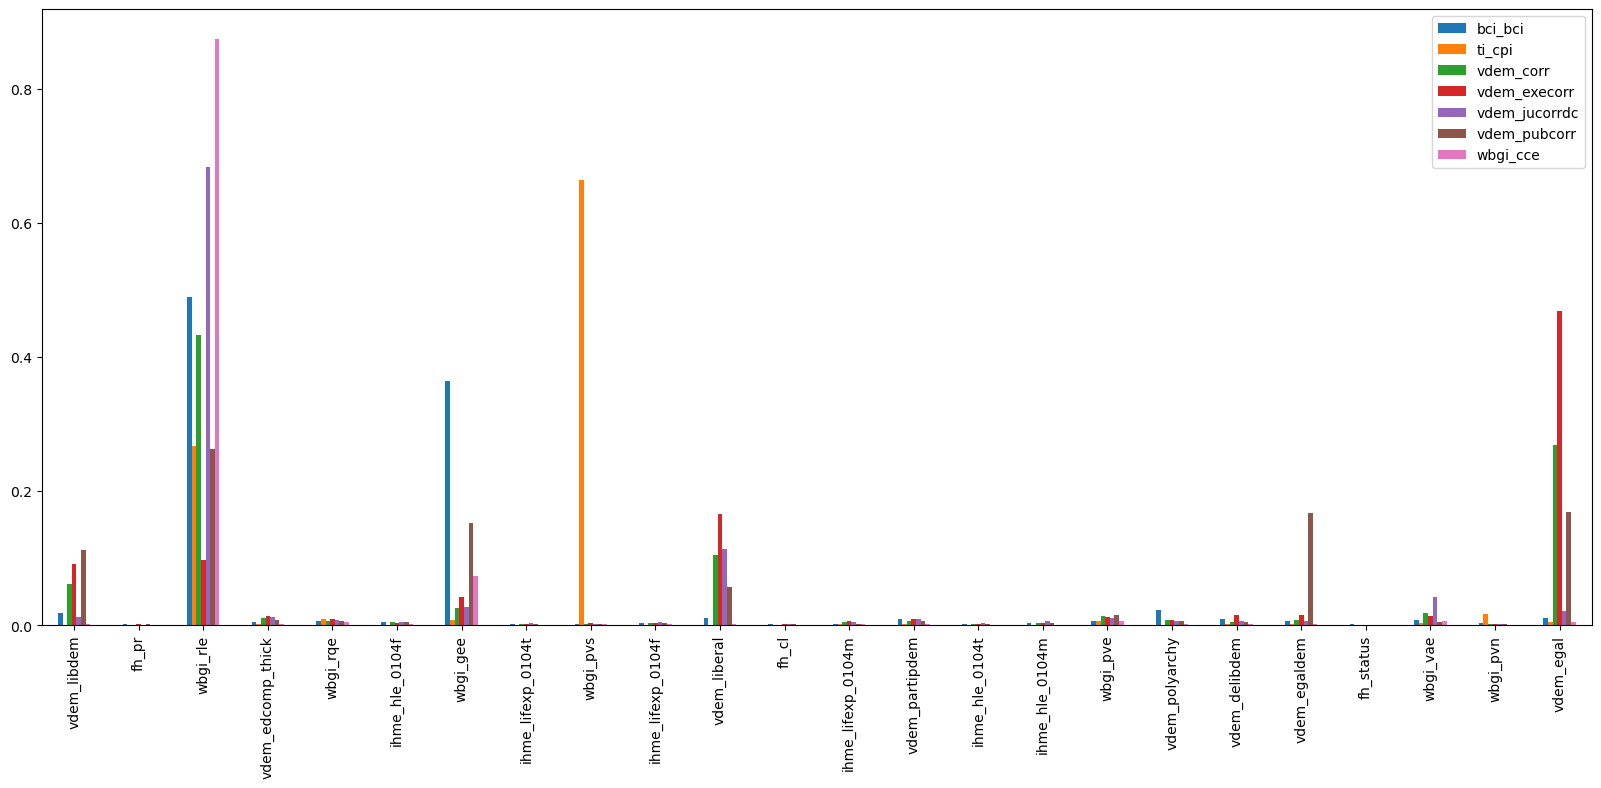

In [13]:
rf_info_script(best_features_union)

Now we use only the features that are in all individually selected feature sets.

scores


,r2,rmse
bci_bci,0.631118,74.985508
ti_cpi,-0.072648,503.204465
vdem_corr,0.652499,0.028389
vdem_execorr,0.577011,0.034874
vdem_jucorrdc,0.28549,0.476934
vdem_pubcorr,0.61751,0.03121
wbgi_cce,0.838974,0.132619


feature importance


,wbgi_rle,wbgi_vae,vdem_egal,wbgi_rqe
bci_bci,0.865292,0.067186,0.041359,0.026163
ti_cpi,0.325791,0.218103,0.20957,0.246536
vdem_corr,0.529624,0.109899,0.330512,0.029965
vdem_execorr,0.197349,0.097186,0.652688,0.052777
vdem_jucorrdc,0.772432,0.11333,0.070235,0.044004
vdem_pubcorr,0.516667,0.123458,0.324254,0.035622
wbgi_cce,0.948858,0.019914,0.01655,0.014679



feature importance rank


,wbgi_rle,wbgi_vae,vdem_egal,wbgi_rqe
bci_bci,1,2,3,4
ti_cpi,1,3,4,2
vdem_corr,1,3,2,4
vdem_execorr,2,3,1,4
vdem_jucorrdc,1,2,3,4
vdem_pubcorr,1,3,2,4
wbgi_cce,1,2,3,4


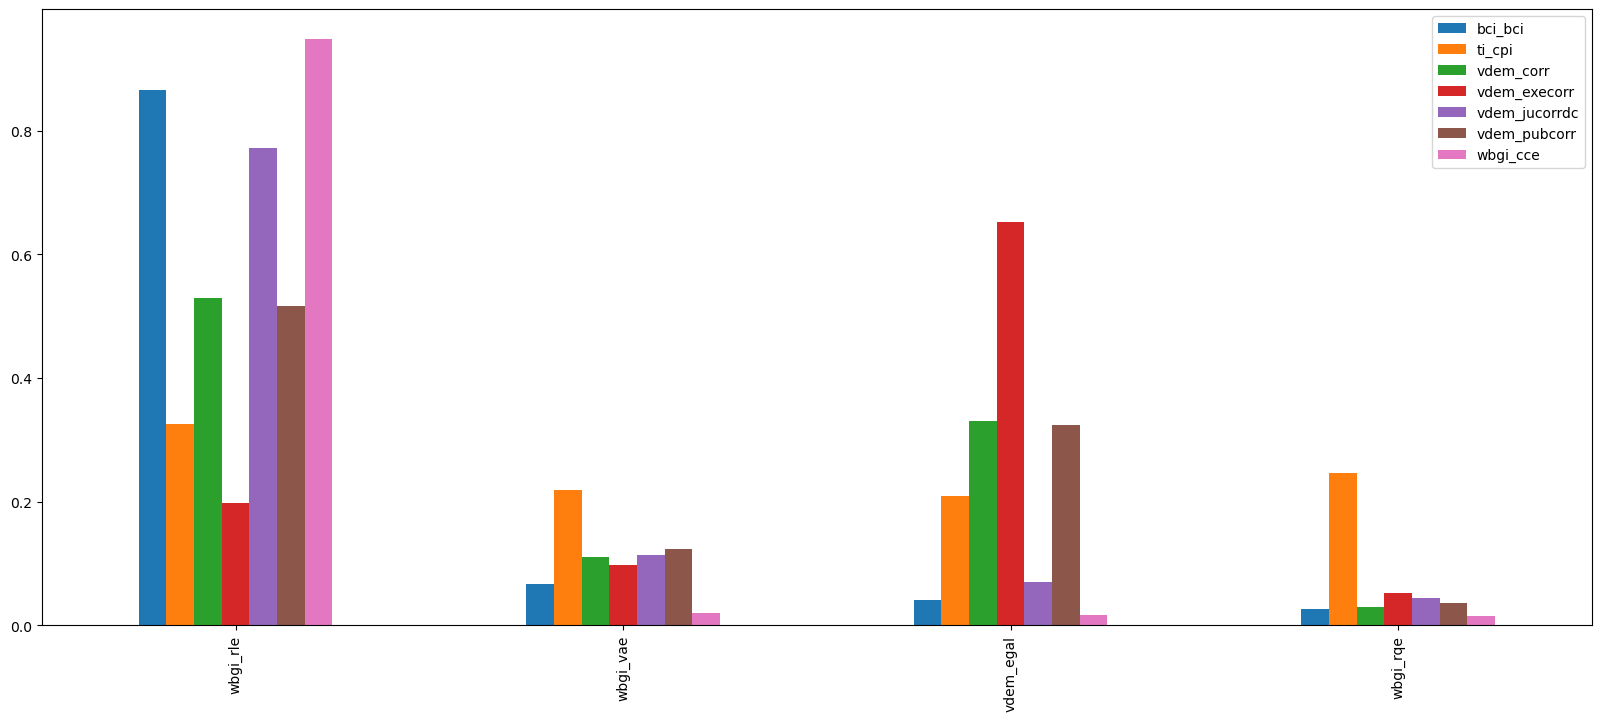

In [14]:
rf_info_script(selected_features_intersection)

The general picture of the results with Random Forest is not that different to the one with Lasso. Some differences are

- ti_cpi is predicted very well now both in comparison with Lasso and with all other indices
- HOWEVER, if only the minimal feature set is used ti_cpi is even worse than with Lasso
- for vdem_execorr the vdem_egal (Egalitarian component index) is the most important feature
- vdem_jucorr is now by far the most difficult to predict index
- although feature importance is not straight-forward comparable between Lasso (weight of coefficients) and Random Forest (Gini) it seems like Random Forst discriminates harder with regard to features

Random Forest performs either similarly or better for most setups / indices allthough no parameter optimization is done by now. So we continue with Random Forst and do hyperparameter optimization for some specific settings next to further optimize the results.

### Grid Search: Random Forest

With cross validation / hyperparameter grid search better parameters are determined. With those optimizations then again models are trained, then the test set is predicted and scores are evaluated.

The script defined below shows a similar report than above.

In [15]:
def rf_gridsearch_info_script(features):
    rf_bf = dict()

    param_grid = {
        "randomforestregressor__max_depth": [2, 3, 5, 10, None],
        "randomforestregressor__min_samples_split": [2, 3, 5, 10],
        "randomforestregressor__max_features": ["log2", None]
        }

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_gridsearch_rf(df, target, list(features[target]), param_grid, fprint=False)
        else:
            rf_bf[target] = apply_gridsearch_rf(df, target, features, param_grid, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)
    rf_bf[target]
    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)
    rf_bf[target]['params']
    l_params = [rf_bf[target]['params'] for target in corr_cols]
    df_params = pd.concat(l_params)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()

    print('params')
    display(df_params)
    print()


Now we only use for each index the individually selected feature set as we saw above that the results are comparable (so the feature selection process works adequately).

scores


,r2,rmse
bci_bci,0.65418,70.297513
ti_cpi,0.934947,30.518041
vdem_corr,0.72569,0.02241
vdem_execorr,0.631461,0.030385
vdem_jucorrdc,0.401289,0.399638
vdem_pubcorr,0.67647,0.026399
wbgi_cce,0.889651,0.090882


feature importance


,vdem_liberal,ihme_lifexp_0104m,wbgi_rle,wbgi_pve,wbgi_rqe,ihme_lifexp_0104t,wbgi_vae,vdem_egal,wbgi_pvs,vdem_egaldem,wbgi_pvn,vdem_polyarchy
bci_bci,0.038053,0.002601,0.918289,0.004014,0.003705,0.002108,0.019903,0.011327,NaN,NaN,NaN,NaN
ti_cpi,NaN,0.002867,0.274135,NaN,0.012018,0.001823,0.005435,0.009644,0.670515,0.003142,0.020421,NaN
vdem_corr,NaN,NaN,0.251608,0.032813,0.106874,NaN,0.202212,0.304512,NaN,NaN,NaN,0.101981
vdem_execorr,NaN,NaN,0.163283,NaN,0.061192,NaN,0.208697,0.409372,NaN,NaN,NaN,0.157456
vdem_jucorrdc,NaN,NaN,0.302665,0.03406,0.21213,NaN,0.248142,0.133633,NaN,NaN,NaN,0.06937
vdem_pubcorr,NaN,NaN,0.225713,0.030296,0.113748,NaN,0.154607,0.292767,NaN,NaN,NaN,0.18287
wbgi_cce,NaN,NaN,0.324745,0.12157,0.267218,NaN,0.147707,0.123181,NaN,NaN,NaN,0.015579



feature importance rank


,vdem_liberal,ihme_lifexp_0104m,wbgi_rle,wbgi_pve,wbgi_rqe,ihme_lifexp_0104t,wbgi_vae,vdem_egal,wbgi_pvs,vdem_egaldem,wbgi_pvn,vdem_polyarchy
bci_bci,2,7,1,5,6,8,3,4,<NA>,<NA>,<NA>,<NA>
ti_cpi,<NA>,8,2,<NA>,4,9,6,5,1,7,3,<NA>
vdem_corr,<NA>,<NA>,2,6,4,<NA>,3,1,<NA>,<NA>,<NA>,5
vdem_execorr,<NA>,<NA>,3,<NA>,5,<NA>,2,1,<NA>,<NA>,<NA>,4
vdem_jucorrdc,<NA>,<NA>,1,6,3,<NA>,2,4,<NA>,<NA>,<NA>,5
vdem_pubcorr,<NA>,<NA>,2,6,5,<NA>,4,1,<NA>,<NA>,<NA>,3
wbgi_cce,<NA>,<NA>,1,5,2,<NA>,3,4,<NA>,<NA>,<NA>,6



params


,randomforestregressor__max_depth,randomforestregressor__max_features,randomforestregressor__min_samples_split
bci_bci,5,None,2
ti_cpi,10,None,3
vdem_corr,10,log2,10
vdem_execorr,5,log2,2
vdem_jucorrdc,5,log2,5
vdem_pubcorr,None,log2,10
wbgi_cce,10,log2,2


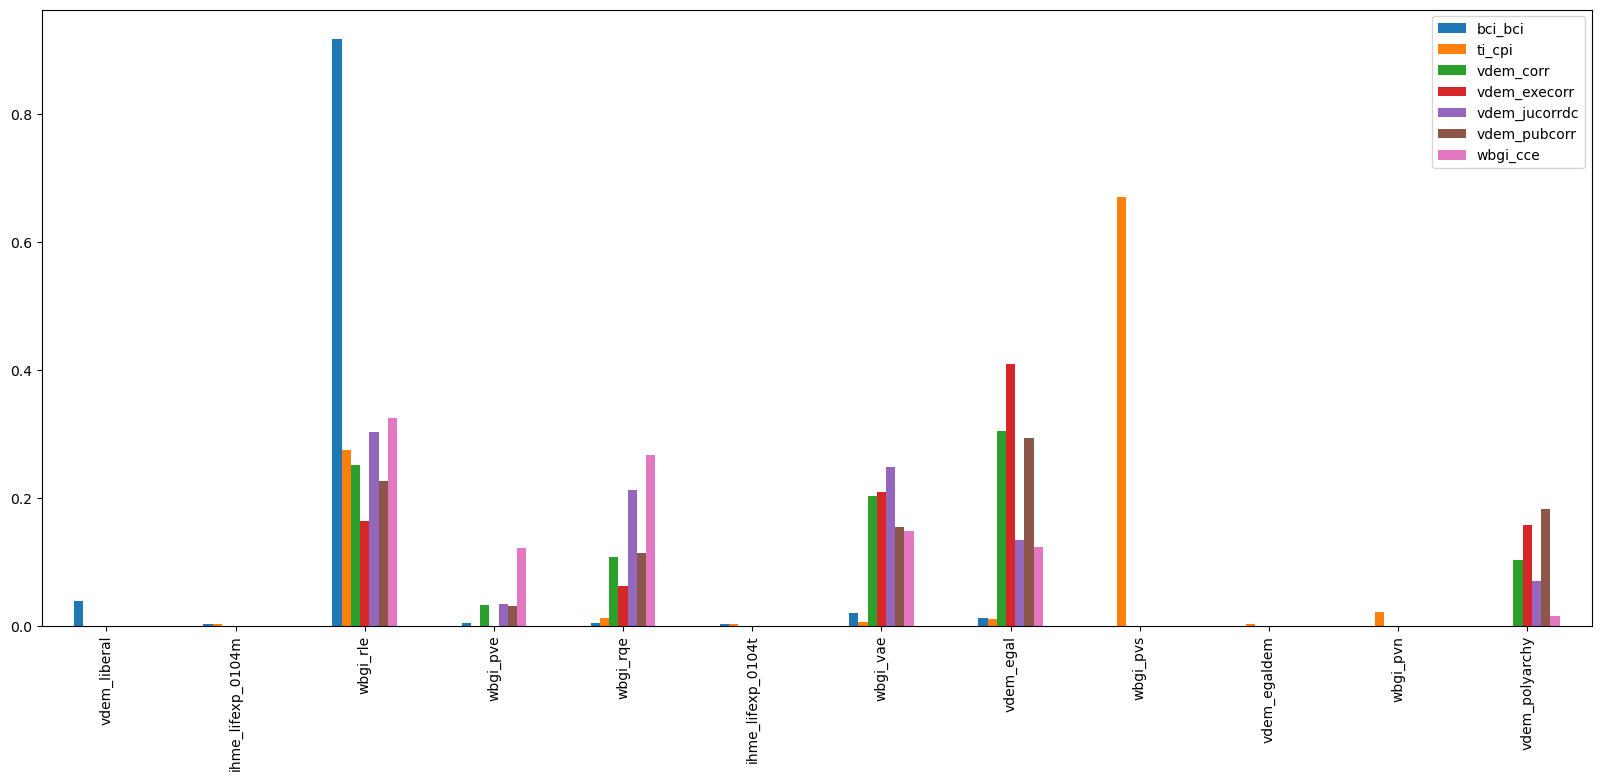

In [19]:
rf_gridsearch_info_script(selected_features_dict)

For most indices the hyperparameter optimization does not seem to significantly improve the r2-scores. But for vdem_jucorrdc it seems to improve. For vdem_pubcorr and wbgi_cce the improvement is minor.

The feature importance (figure) changes a lot more. Here we see for all but bci_bci that relatively wbgi_rle is not as important anymore. This is most likely due to the max_samples_features being log2 now. One could argue if the original model where wbgi_rle is the main feature is simpler and from the same quality or on the other side that other features are also able to replace wbgi_rle when combined.